# Oil Spill Detection from Sentinel-1 Data



***

- This project aims to detect oil spills from Sentinel-1 Synthetic Aperture Radar (SAR) images using a **Conditional Generative Adversarial Network (CGAN)** with a **Seg-Net generator**. The model predicts segmentation masks highlighting oil spill regions, calculates their surface area, and identifies their geographical location.





#### References :

1. [Deep neural network for oil spill detection using Sentinel-1 data: application to Egyptian coastal regions by Samira Ahmed,Tamer ElGharbawi,Mahmoud Salah & Mahmoud El-Mewafi](https://www.tandfonline.com/doi/full/10.1080/19475705.2022.2155998#abstract)



2. [pix2pix: Image-to-image translation with a conditional GAN](https://www.tensorflow.org/tutorials/generative/pix2pix)

3. [Dataset](https://drive.google.com/file/d/15WYzzFZvAHmqSIW0PXXRTp_YVd_868l8/view)


## Project setup and Libraries :

In [94]:
# Imports

import tensorflow as tf

from tensorflow.keras.layers import Conv2D, Conv2DTranspose, BatchNormalization, ReLU, LeakyReLU, Dropout, Input, Concatenate,MaxPooling2D,UpSampling2D

from tensorflow.keras.optimizers import Adam

from tensorflow.keras.models import Model

import matplotlib.pyplot as plt

import os

import cv2

import numpy as np

from sklearn.model_selection import train_test_split

from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, mean_squared_error

from skimage.metrics import structural_similarity as ssim

## Data loading and Preprocessing :



- we used the dataset from this [paper](https://www.google.com/url?q=https%3A%2F%2Fwww.tandfonline.com%2Fdoi%2Ffull%2F10.1080%2F19475705.2022.2155998%23abstract) which consists of preprocessed raw images and Ground Truth Masks **(GTM)** and was obtained by the Sentinel-1 mission satellite level-1 Ground Range Detected (GRD), which is equipped with a C-band SAR system and distributed by the European Space Agency (ESA) via the Copernicus Open Access Hub. [1](https://www.tandfonline.com/doi/full/10.1080/19475705.2022.2155998#d1e241:~:text=The%20dataset%20mentioned,Open%20Access%20Hub.)

In [100]:
def preprocess_images(raw_img, gtm_img, target_size=(256, 256)):
    # Normalize raw image to range [-1, 1]
    raw_img = (raw_img / 127.5) - 1.0
    gtm_img = (gtm_img / 255.0) - 1.0

    return raw_img, gtm_img

In [110]:
# Function to load and process data
def load_data(raw_images_path, gtm_images_path, img_size=(256, 256)):

    raw_images, gtm_images = [], []

    for img_name in os.listdir(raw_images_path):

        raw_img_path = os.path.join(raw_images_path, img_name)
        gtm_img_path = os.path.join(gtm_images_path, img_name)

        # Load raw and GTM images
        raw_img = cv2.imread(raw_img_path, cv2.IMREAD_GRAYSCALE)
        gtm_img = cv2.imread(gtm_img_path, cv2.IMREAD_GRAYSCALE)

        # cast to float32
        raw_img = tf.cast(raw_img,tf.float32)
        gtm_img = tf.cast(gtm_img,tf.float32)

        # process data
        raw_img_p , gtm_img_p = preprocess_images(raw_img,gtm_img)
        
        # Add images to lists
        raw_images.append(raw_img_p)
        gtm_images.append(gtm_img_p)



    raw_images = np.expand_dims(np.array(raw_images), axis=-1)
    gtm_images = np.expand_dims(np.array(gtm_images), axis=-1)

    return raw_images, gtm_images

In [111]:
# Paths to images

raw_images_path = "/kaggle/input/raw-images"
gtm_images_path = "/kaggle/input/ground-truth-masks"



# Load data

raw_images, gtm_images = load_data(raw_images_path, gtm_images_path)



print("Images shape:", raw_images.shape)

print("Masks shape:", gtm_images.shape)

Images shape: (695, 256, 256, 1)
Masks shape: (695, 256, 256, 1)


In [112]:
print("Raw Image Range:", np.min(raw_images), np.max(raw_images))
print("Ground Truth Mask Range:", np.min(gtm_images), np.max(gtm_images))

Raw Image Range: -1.0 1.0
Ground Truth Mask Range: -1.0 0.0


In [ ]:
# Data Augmentation (horizontal, vertical flips, and random rotations)
def data_augmentation(image, mask):

    # Random horizontal flip
    if tf.random.uniform(()) > 0.5:
        image, mask = tf.image.flip_left_right(image), tf.image.flip_left_right(mask)

    # Random vertical flip
    if tf.random.uniform(()) > 0.5:
        image, mask = tf.image.flip_up_down(image), tf.image.flip_up_down(mask)

    # Random rotations (90, 180, 270 degrees)
    num_rotations = tf.random.uniform((), minval=0, maxval=4, dtype=tf.int32) 
    image, mask = tf.image.rot90(image, k=num_rotations), tf.image.rot90(mask, k=num_rotations)

    return image, mask

In [ ]:
# splitting the data
train_images, temp_images, train_masks, temp_masks = train_test_split(raw_images, gtm_images, test_size=0.3, random_state=42)
val_images, test_images, val_masks, test_masks = train_test_split(temp_images, temp_masks, test_size=0.6, random_state=42)



# Output the shapes of the datasets to verify
print("Training set:", train_images.shape, train_masks.shape)
print("Validation set:", val_images.shape, val_masks.shape)
print("Test set:", test_images.shape, test_masks.shape)

Training set: (486, 256, 256, 1) (486, 256, 256, 1)
Validation set: (83, 256, 256, 1) (83, 256, 256, 1)
Test set: (126, 256, 256, 1) (126, 256, 256, 1)


In [ ]:
# Display sample images and masks
def display_samples(images, masks, num_samples=2):

    plt.figure(figsize=(10, 5 * num_samples))
    for i in range(num_samples):
      # display raw image
        plt.subplot(num_samples, 2, i * 2 + 1)
        plt.imshow(images[i].squeeze(), cmap="gray")
        plt.title("Raw Image")
        plt.axis("off")

        # display mask image
        plt.subplot(num_samples, 2, i * 2 + 2)
        plt.imshow(masks[i].squeeze(), cmap="gray")
        plt.title("Ground Truth Mask (GTM)")
        plt.axis("off")

    plt.tight_layout()
    plt.show()

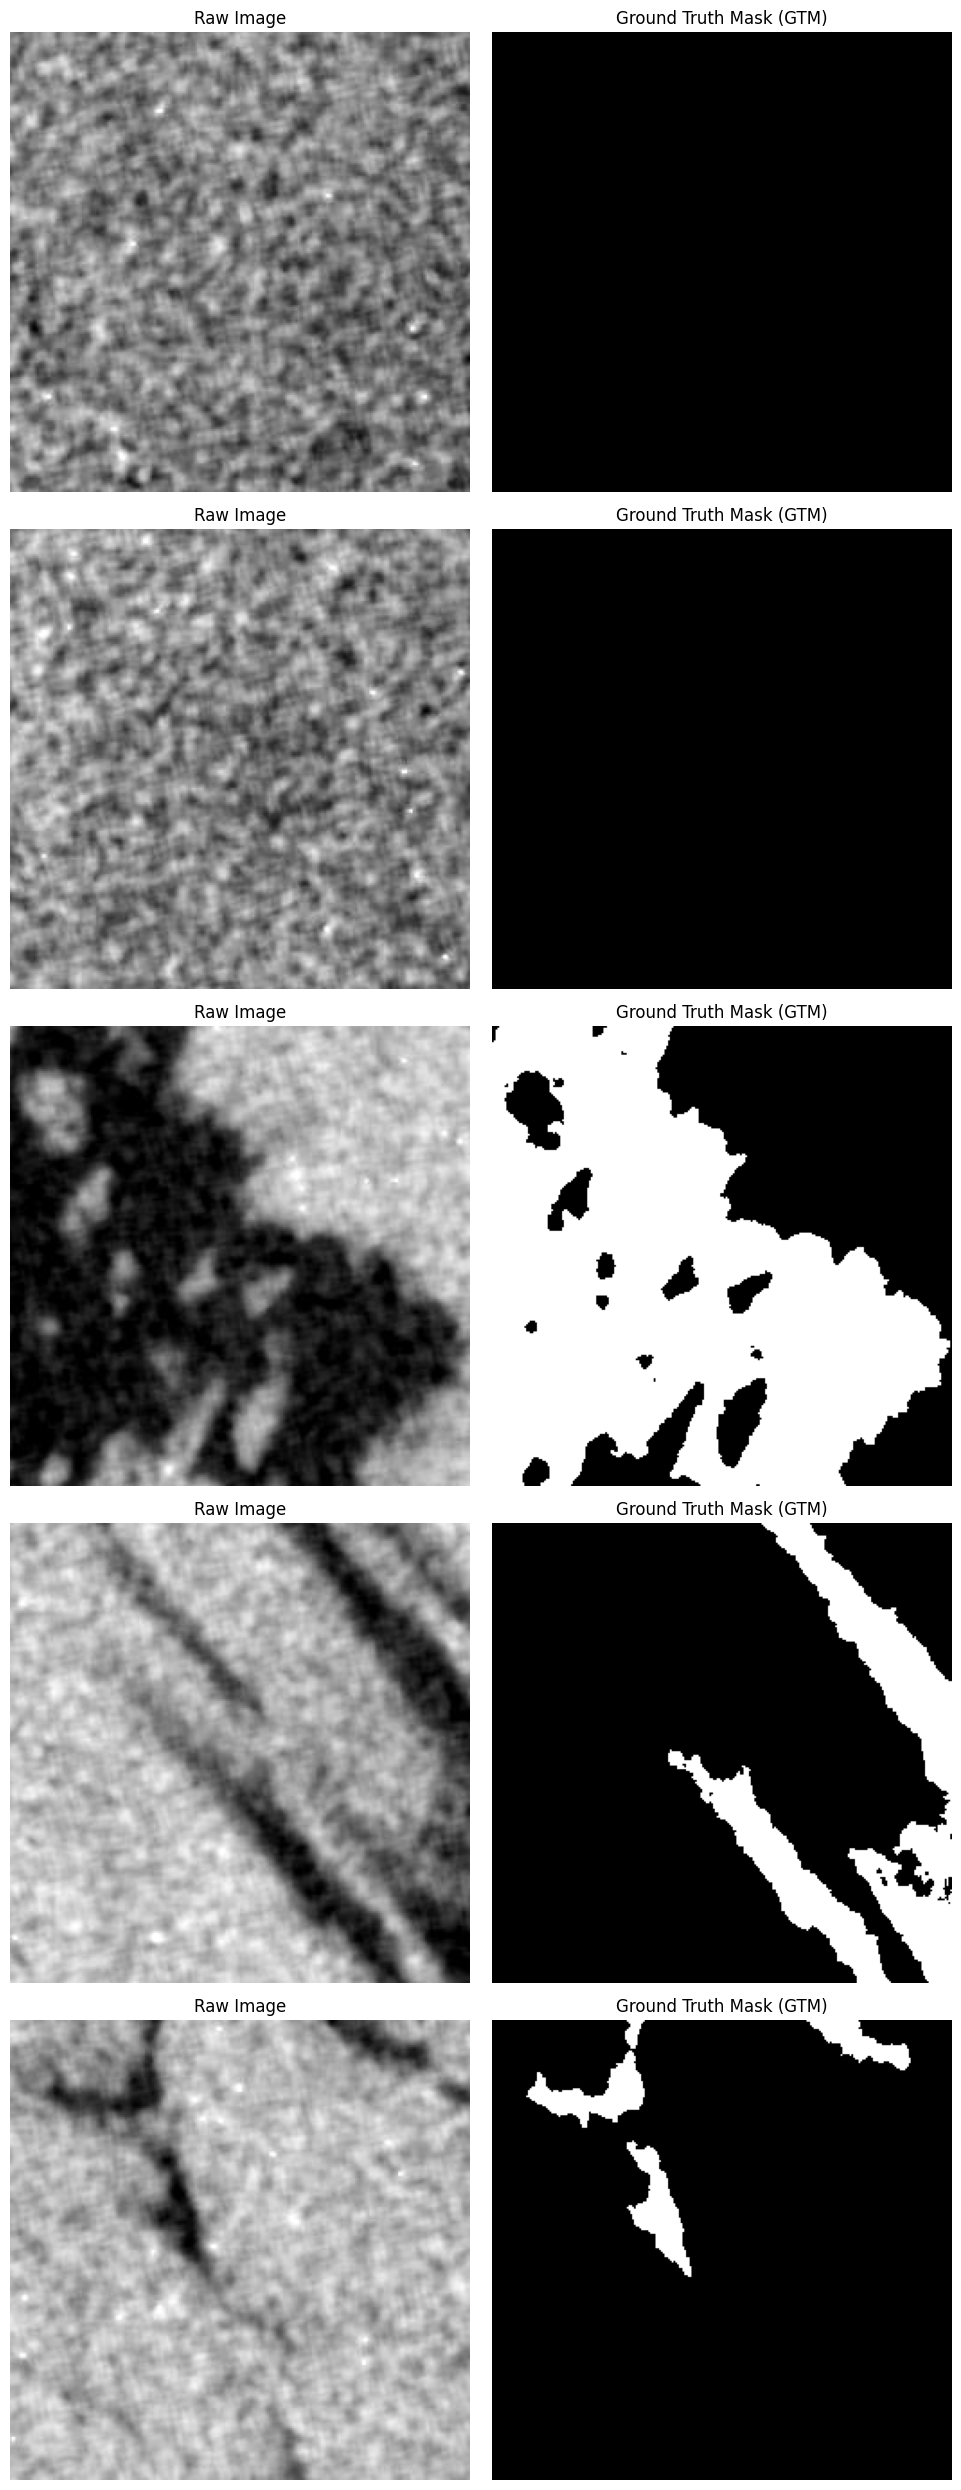

In [66]:
display_samples(train_images, train_masks, num_samples=5)

In [ ]:
# Convert datasets to TensorFlow format

train_dataset = tf.data.Dataset.from_tensor_slices((train_images, train_masks)).shuffle(100).batch(1)
val_dataset = tf.data.Dataset.from_tensor_slices((val_images, val_masks)).batch(1)
test_dataset = tf.data.Dataset.from_tensor_slices((test_images, test_masks)).batch(1)

In [ ]:
# Augmenting the training dataset
train_dataset = train_dataset.map(lambda x, y: data_augmentation(x, y)).prefetch(tf.data.AUTOTUNE)

## Model Architecture

We use a Conditional GAN for oil spill detection



1. The **Seg-Net generator** predicts segmentation masks highlighting oil spill regions.

2. The **Patch-GAN discriminator** distinguishes between real and generated masks, improving the generator's performance during training.




### Define Seg-Net Generator:


In [117]:
def build_generator(input_shape=(256, 256, 1)):
    inputs = Input(shape=input_shape)
    x = Conv2D(64, kernel_size=4, strides=2, padding='same')(inputs)
    x = BatchNormalization()(x)
    x = ReLU()(x)

    x = Conv2D(128, kernel_size=4, strides=2, padding='same')(x)
    x = BatchNormalization()(x)
    x = ReLU()(x)

    x = Conv2D(256, kernel_size=4, strides=2, padding='same')(x)
    x = BatchNormalization()(x)
    x = ReLU()(x)

    x = Conv2D(512, kernel_size=4, strides=2, padding='same')(x)
    x = BatchNormalization()(x)
    x = ReLU()(x)

    x = Conv2DTranspose(256, kernel_size=4, strides=2, padding='same')(x)
    x = BatchNormalization()(x)
    x = ReLU()(x)

    x = Conv2DTranspose(128, kernel_size=4, strides=2, padding='same')(x)
    x = BatchNormalization()(x)
    x = ReLU()(x)

    x = Conv2DTranspose(64, kernel_size=4, strides=2, padding='same')(x)
    x = BatchNormalization()(x)
    x = ReLU()(x)

    outputs = Conv2DTranspose(1, kernel_size=4, strides=2, padding='same', activation='sigmoid')(x)
    return Model(inputs, outputs, name='generator')


### Define Patch-GAN Discriminator:

- Evaluates the realism of generated segmentation masks.

In [ ]:
# Build Patch-GAN Discriminator

def build_discriminator(input_shape=(256, 256, 1)):
    input_image, input_mask = Input(shape=input_shape), Input(shape=input_shape)
    
    x = Concatenate()([input_image, input_mask])
    x = Conv2D(64, kernel_size=4, strides=2, padding='same')(x)
    x = LeakyReLU(0.2)(x)


    x = Conv2D(128, kernel_size=4, strides=2, padding='same')(x)
    x = BatchNormalization()(x)
    x = LeakyReLU(0.2)(x)

    x = Conv2D(256, kernel_size=4, strides=2, padding='same')(x)
    x = BatchNormalization()(x)
    x = LeakyReLU(0.2)(x)

    x = Conv2D(512, kernel_size=4, strides=1, padding='same')(x)
    x = BatchNormalization()(x)
    x = LeakyReLU(0.2)(x)

    outputs = Conv2D(1, kernel_size=4, strides=1, padding='same', activation='sigmoid')(x)
    return Model([input_image, input_mask], outputs, name='discriminator')

In [120]:
# initializing the generator
generator = build_generator()

generator.summary()

# tf.keras.utils.plot_model(generator, show_shapes=True, show_layer_names=True)

Model: "generator"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_4 (InputLayer)      │ (None, 256, 256, 1)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_13 (Conv2D)              │ (None, 128, 128, 64)   │         1,088 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_17          │ (None, 128, 128, 64)   │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ re_lu_14 (ReLU)                 │ (None, 128, 128, 64)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_14 (Conv2D)              │ (None, 64, 64, 128)    │       131,200 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_18          │ (None, 64, 64, 128)    │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ re_lu_15 (ReLU)                 │ (None, 64, 64, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_15 (Conv2D)              │ (None, 32, 32, 256)    │       524,544 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_19          │ (None, 32, 32, 256)    │         1,024 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ re_lu_16 (ReLU)                 │ (None, 32, 32, 256)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_16 (Conv2D)              │ (None, 16, 16, 512)    │     2,097,664 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_20          │ (None, 16, 16, 512)    │         2,048 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ re_lu_17 (ReLU)                 │ (None, 16, 16, 512)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_transpose_8              │ (None, 32, 32, 256)    │     2,097,408 │
│ (Conv2DTranspose)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_21          │ (None, 32, 32, 256)    │         1,024 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ re_lu_18 (ReLU)                 │ (None, 32, 32, 256)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_transpose_9              │ (None, 64, 64, 128)    │       524,416 │
│ (Conv2DTranspose)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_22          │ (None, 64, 64, 128)    │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ re_lu_19 (ReLU)                 │ (None, 64, 64, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_transpose_10             │ (None, 128, 128, 64)   │       131,136 │
│ (Conv2DTranspose)               │                        │               │
├─────────────────────────────────┼────────────────────────┼─────────────

 Total params: 5,514,113 (21.03 MB)

 Trainable params: 5,511,297 (21.02 MB)

 Non-trainable params: 2,816 (11.00 KB)

In [121]:
# initializing the discriminator
discriminator = build_discriminator()

discriminator.summary()

#tf.keras.utils.plot_model(discriminator, show_shapes=True)

Model: "discriminator"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_5       │ (None, 256, 256,  │          0 │ -                 │
│ (InputLayer)        │ 1)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ input_layer_6       │ (None, 256, 256,  │          0 │ -                 │
│ (InputLayer)        │ 1)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ concatenate_1       │ (None, 256, 256,  │          0 │ input_layer_5[0]… │
│ (Concatenate)       │ 2)                │            │ input_layer_6[0]… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_17 (Conv2D)  │ (None, 128, 128,  │      2,112 │ concatenate_1[0]… │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ leaky_re_lu_4       │ (None, 128, 128,  │          0 │ conv2d_17[0][0]   │
│ (LeakyReLU)         │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_18 (Conv2D)  │ (None, 64, 64,    │    131,200 │ leaky_re_lu_4[0]… │
│                     │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 64, 64,    │        512 │ conv2d_18[0][0]   │
│ (BatchNormalizatio… │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ leaky_re_lu_5       │ (None, 64, 64,    │          0 │ batch_normalizat… │
│ (LeakyReLU)         │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_19 (Conv2D)  │ (None, 32, 32,    │    524,544 │ leaky_re_lu_5[0]… │
│                     │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 32, 32,    │      1,024 │ conv2d_19[0][0]   │
│ (BatchNormalizatio… │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ leaky_re_lu_6       │ (None, 32, 32,    │          0 │ batch_normalizat… │
│ (LeakyReLU)         │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_20 (Conv2D)  │ (None, 32, 32,    │  2,097,664 │ leaky_re_lu_6[0]… │
│                     │ 512)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 32, 32,    │      2,048 │ conv2d_20[0][0]   │
│ (BatchNormalizatio… │ 512)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ leaky_re_lu_7       │ (None, 32, 32,    │          0 │ batch_normalizat… │
│ (LeakyReLU)         │ 512)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_21 (Conv2D)  │ (None, 32, 32, 1) │      8,193 │ leaky_re_lu_7[0]… │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 2,767,297 (10.56 MB)

 Trainable params: 2,765,505 (10.55 MB)

 Non-trainable params: 1,792 (7.00 KB)

### Load Pretrained model weights :

In [ ]:
# if model is already trained Load the weights saved in the path
# Define the path to save the weights

weights_path = './saved_model.weights.h5'

generator.load_weights(weights_path)
print("Weights loaded successfully. Model is ready")

Weights loaded successfully. Model is ready


In [ ]:
# Initialize optimizers
generator_optimizer = tf.keras.optimizers.Adam(1e-4, beta_1=0.9)
discriminator_optimizer = tf.keras.optimizers.Adam(1e-4, beta_1=0.999)

In [ ]:
# Define loss functions

def generator_loss(disc_generated_output, gen_output, target):
    gan_loss = tf.keras.losses.BinaryCrossentropy(from_logits=False)(tf.ones_like(disc_generated_output), disc_generated_output)
    l1_loss = tf.reduce_mean(tf.abs(target - gen_output))
    return gan_loss + (100 * l1_loss)

def discriminator_loss(disc_real_output, disc_generated_output):
    real_loss = tf.keras.losses.BinaryCrossentropy(from_logits=False)(tf.ones_like(disc_real_output), disc_real_output)
    fake_loss = tf.keras.losses.BinaryCrossentropy(from_logits=False)(tf.zeros_like(disc_generated_output), disc_generated_output)
    return real_loss + fake_loss


In [96]:
def compute_metrics(y_true, y_pred):
    # Ensure input arrays are numpy arrays
    y_true = np.array(y_true).squeeze()
    y_pred = np.array(y_pred).squeeze()
    y_pred = np.round(y_pred)
    
    # Binarize the array (convert 255 to 1 for oil spill, keep 0 for background)
    y_pred_binary = np.where(y_pred == 255, 1, 0)

    # Flatten the arrays for metric computation
    y_true_flat = y_true.flatten()
    y_pred_flat = y_pred_binary.flatten()

    # Check for edge cases where all pixels are zero (no oil spill)
    if np.sum(y_true_flat) == 0:
        return {
            'accuracy': accuracy_score(y_true_flat, y_pred_flat),
            'precision': 1.0 if np.sum(y_pred_flat) == 0 else 0.0,  # No false positives
            'recall': 1.0,  # No false negatives
            'f1_score': 1.0 if np.sum(y_pred_flat) == 0 else 0.0,  # Perfect F1 if no oil spill
            'iou': 1.0 if np.sum(y_pred_flat) == 0 else 0.0,  # No intersection
            'rmse': np.sqrt(mean_squared_error(y_true_flat, y_pred_flat)),
            'ssim': 1.0,  # Structural similarity is perfect if there's no oil spill
            'psnr': 100,  # High PSNR when no oil spill (perfect match)
        }

    # Compute IoU for non-empty cases
    intersection = np.logical_and(y_true_flat == 1, y_pred_flat == 1).sum()
    union = np.logical_or(y_true_flat == 1, y_pred_flat == 1).sum()
    iou = intersection / (union + 1e-6) if union > 0 else 0

    return {
        'accuracy': accuracy_score(y_true_flat, y_pred_flat),
        'precision': precision_score(y_true_flat, y_pred_flat, zero_division=0),
        'recall': recall_score(y_true_flat, y_pred_flat, zero_division=0),
        'f1_score': f1_score(y_true_flat, y_pred_flat, zero_division=0),
        'iou': iou,
        'rmse': np.sqrt(mean_squared_error(y_true_flat, y_pred_flat)),
        'ssim': ssim(y_true, y_pred, data_range=1),
        'psnr': 20 * np.log10(1 / np.sqrt(mean_squared_error(y_true_flat, y_pred_flat) + 1e-6)),
    }

In [88]:
@tf.function
def train_step(generator, discriminator, input_image, target):
    with tf.GradientTape() as gen_tape, tf.GradientTape() as disc_tape:
        gen_output = generator(input_image, training=True)

        # Calculate losses
        disc_real_output = discriminator([input_image, target], training=True)
        disc_generated_output = discriminator([input_image, gen_output], training=True)

        gen_loss = generator_loss(disc_generated_output, gen_output, target)
        disc_loss = discriminator_loss(disc_real_output, disc_generated_output)

    # Apply gradients
    generator_gradients = gen_tape.gradient(gen_loss, generator.trainable_variables)
    discriminator_gradients = disc_tape.gradient(disc_loss, discriminator.trainable_variables)

    generator_optimizer.apply_gradients(zip(generator_gradients, generator.trainable_variables))
    discriminator_optimizer.apply_gradients(zip(discriminator_gradients, discriminator.trainable_variables))

    return gen_loss, disc_loss, tf.round(gen_output)

In [ ]:
def train(train_dataset, generator, discriminator, epochs):
    # Initialize a dictionary to store metrics for each epoch
    train_metrics = {
        'accuracy': [], 'precision': [], 'recall': [], 'f1_score': [],
        'iou': [], 'rmse': [], 'ssim': [], 'psnr': []
    }

    for epoch in range(epochs):
        print(f'\nEpoch {epoch + 1}/{epochs}')

        total_gen_loss, total_disc_loss = 0, 0
        epoch_metrics = {key: [] for key in train_metrics.keys()}

        for input_image, target in train_dataset:
            gen_loss, disc_loss, gen_output = train_step(generator, discriminator, input_image, target)

            # Accumulate losses
            total_gen_loss += gen_loss.numpy()
            total_disc_loss += disc_loss.numpy()

            # Compute metrics for the current batc
            batch_metrics = compute_metrics(target.numpy(), gen_output.numpy())
            for key, value in batch_metrics.items():
                epoch_metrics[key].append(value)  # Collect batch metrics

        # Average losses over the epoch
        avg_gen_loss = total_gen_loss / len(train_dataset)
        avg_disc_loss = total_disc_loss / len(train_dataset)

        # Average metrics for the epoch
        avg_epoch_metrics = {key: np.mean(values) for key, values in epoch_metrics.items()}
        for key, value in avg_epoch_metrics.items():
            train_metrics[key].append(value)  # Store epoch-level metrics

        # Print losses and metrics
        print(f"Train Generator Loss: {avg_gen_loss:.4f}, Train Discriminator Loss: {avg_disc_loss:.4f}")
        print("Metrics: " + ", ".join([f"{key}: {value:.4f}" for key, value in avg_epoch_metrics.items()]))

    return train_metrics

In [ ]:
# Display a few predictions using provided images, masks, and predictions

def display_predictions(images, masks, predictions, num_samples=5):

    plt.figure(figsize=(15, 5 * num_samples))

    for i in range(num_samples):
        # Display the raw input image
        plt.subplot(num_samples, 3, i * 3 + 1)
        plt.imshow(images[i].squeeze(), cmap="gray")
        plt.title("Raw Image")
        plt.axis("off")
        
        # Display the ground truth mask
        plt.subplot(num_samples, 3, i * 3 + 2)
        plt.imshow(masks[i].squeeze(), cmap="gray")
        plt.title("Ground Truth Mask (GTM)")
        plt.axis("off")
        
        # Display the predicted mask
        plt.subplot(num_samples, 3, i * 3 + 3)
        plt.imshow((predictions[i].squeeze() * 255).astype(np.uint8), cmap="gray")
        plt.title("Predicted Mask")
        plt.axis("off")

    plt.tight_layout()
    plt.show()

In [ ]:
# Function to plot training metrics
def plot_metrics(train_metrics, epochs):
    
    epochs_range = range(1, epochs + 1)
    plt.figure(figsize=(20, 12))

    metric_names = ['accuracy', 'precision', 'recall', 'f1_score', 'iou', 'rmse', 'ssim']
    for i, metric in enumerate(metric_names, 1):
        plt.subplot(2, 4, i)
        plt.plot(epochs_range, train_metrics[metric], label=f"Train {metric.capitalize()}", marker='o')
        plt.xlabel("Epochs")
        plt.ylabel(metric.capitalize())
        plt.title(f"{metric.capitalize()} Over Epochs")
        plt.legend()
        plt.grid(True)

    plt.tight_layout()
    plt.show()

In [ ]:
# Run the training with metrics tracking
avg_training_metrics = train(train_dataset, generator, discriminator, epochs=100)


Epoch 1/10
Train Generator Loss: 10.0856, Train Discriminator Loss: 0.8515
Metrics: accuracy: 0.9198, precision: 0.5638, recall: 0.5638, f1_score: 0.5638, iou: 0.5638, rmse: 0.1586, ssim: 0.9016, psnr: 61.2106

Epoch 2/10
Train Generator Loss: 10.1742, Train Discriminator Loss: 0.8465
Metrics: accuracy: 0.9198, precision: 0.5638, recall: 0.5638, f1_score: 0.5638, iou: 0.5638, rmse: 0.1586, ssim: 0.9016, psnr: 61.2106

Epoch 3/10
Train Generator Loss: 10.0753, Train Discriminator Loss: 0.8459
Metrics: accuracy: 0.9198, precision: 0.5638, recall: 0.5638, f1_score: 0.5638, iou: 0.5638, rmse: 0.1586, ssim: 0.9016, psnr: 61.2106

Epoch 4/10
Train Generator Loss: 10.2180, Train Discriminator Loss: 0.8471
Metrics: accuracy: 0.9198, precision: 0.5638, recall: 0.5638, f1_score: 0.5638, iou: 0.5638, rmse: 0.1586, ssim: 0.9016, psnr: 61.2106

Epoch 5/10
Train Generator Loss: 10.1250, Train Discriminator Loss: 0.8438
Metrics: accuracy: 0.9198, precision: 0.5638, recall: 0.5638, f1_score: 0.5638, 

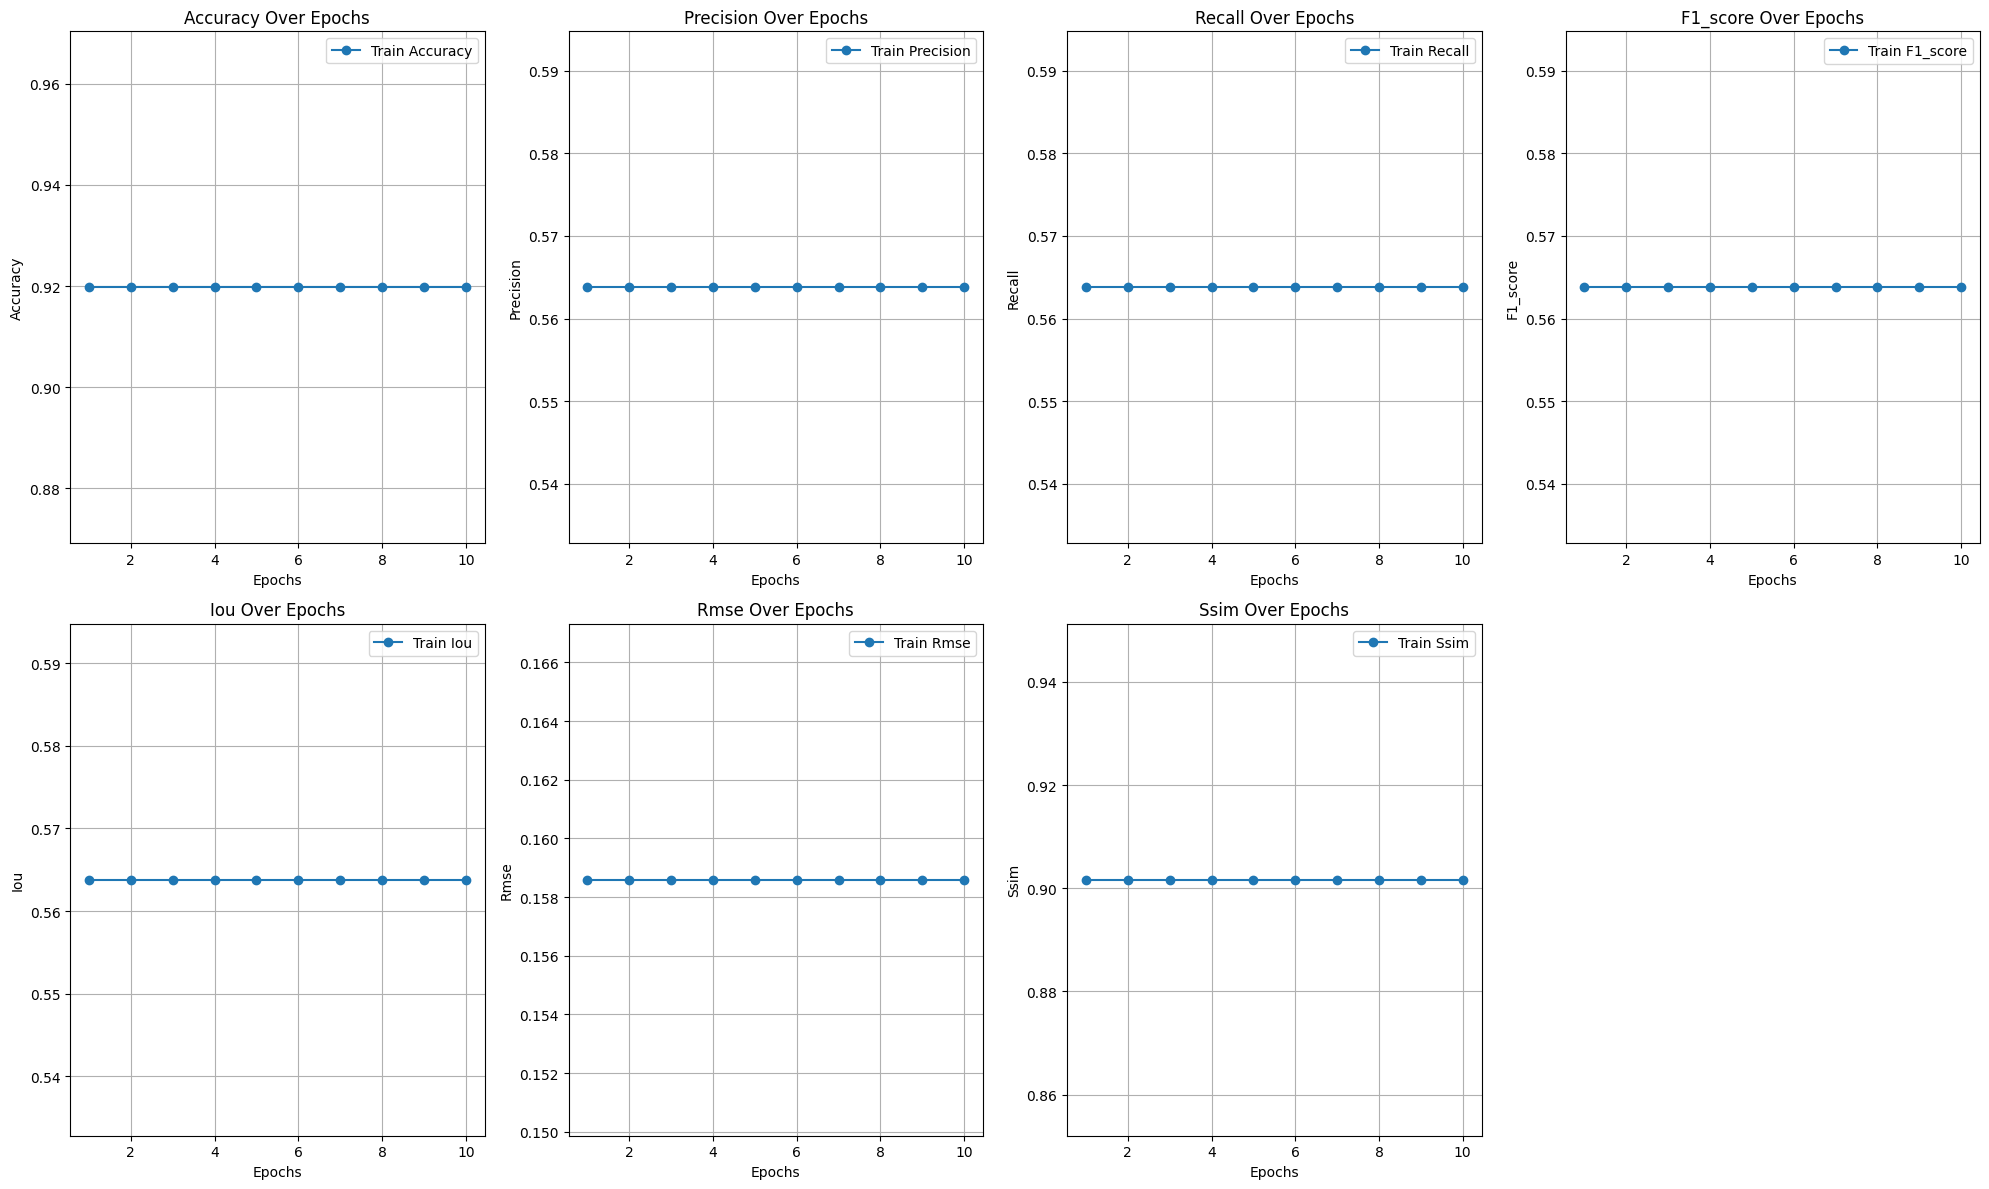

In [101]:
plot_metrics(avg_training_metrics, epochs=10)

## Evaluation and Results

In [123]:
def predict_dataset(generator, dataset):
    predictions = []
    for input_image, _ in dataset:
        prediction = generator(input_image, training=False)
        predictions.append(prediction.numpy().squeeze())

    return np.array(np.round(predictions))

In [124]:
predictions = predict_dataset(generator,val_dataset)

In [ ]:
def evaluate_model(generator, dataset):
    # Initialize metrics and prediction storage
    metrics_agg = {
        'accuracy': [], 'precision': [], 'recall': [], 'f1_score': [],
        'iou': [], 'rmse': [], 'ssim': [], 'psnr': []}

    all_predictions = []
    # Iterate over the dataset
    for idx, (image, mask) in enumerate(dataset):
        # Generate predictions for the batch
        predictions = tf.round(generator(image, training=False)).numpy()
        targets = mask.numpy()

        # Compute and aggregate metrics for each image in the batch
        for i, prediction in enumerate(predictions):
            batch_metrics = compute_metrics(targets[i].squeeze(), prediction.squeeze())
            for k, v in batch_metrics.items():
                metrics_agg[k].append(v)

    # Calculate average metrics over the entire dataset
    metrics_avg = {k: np.mean(v) for k, v in metrics_agg.items()}
    print(" Set Metrics:", metrics_avg)

    return metrics_avg, np.array(all_predictions)

In [ ]:
# evaluate model
test_metrics,predictions = evaluate_model(generator, val_dataset)

 Set Metrics: {'accuracy': 1.0, 'precision': 1.0, 'recall': 1.0, 'f1_score': 1.0, 'iou': 1.0, 'rmse': 0.0, 'ssim': 1.0, 'psnr': 100.0}


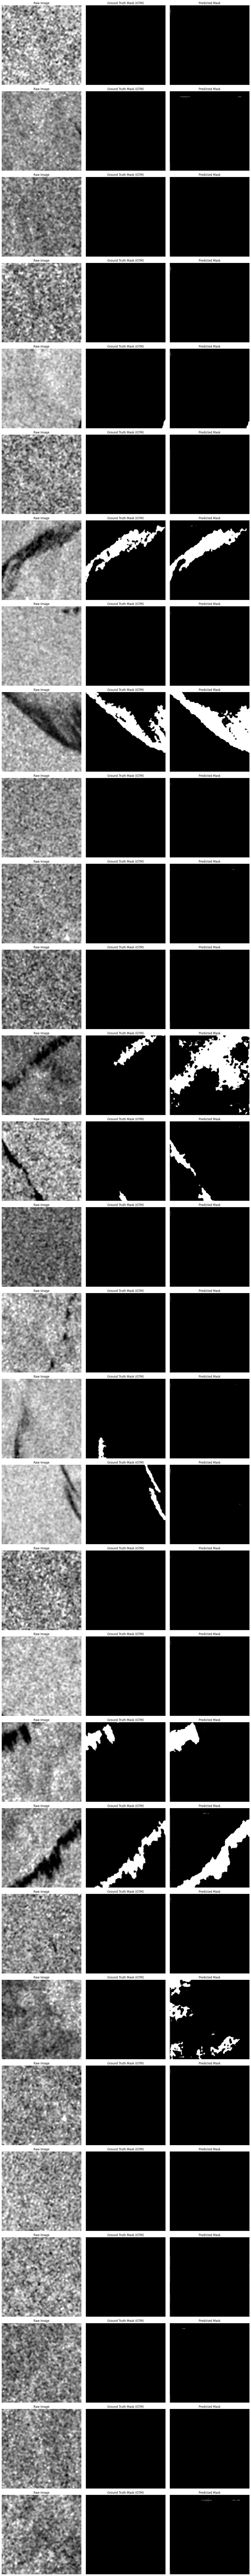

In [ ]:
# Display predictions for validation dataset
display_predictions(val_images, val_masks,predictions, num_samples=30)

## Calculating oil spill size and surface :

In [ ]:
# function to calculate the oil spill size and surface from the predicted ground truth mask
def calculate_oil_spill_size(predicted_mask, pixel_resolution):

    # Threshold the predicted mask to create a binary mask
    binary_mask = (predicted_mask >= 0.7).astype(int)  # 1 = oil spill, 0 = no spill

    # Check if any oil spill pixels are present
    # if spill count is more than 1% of the total image pixels

    spill_pixel_count = np.sum(binary_mask)

    spill_exists = spill_pixel_count > (255*255*0.01)

    # Calculate surface area (spill_pixel_count * pixel_width * pixel_height)
    pixel_width, pixel_height = pixel_resolution
    spill_surface = spill_pixel_count * pixel_width * pixel_height if spill_exists else 0

    return spill_exists, spill_surface

In [ ]:
pixel_resolution = 1.0 , 1.0 # meters

image_index = 60

spill_detected , spill_surface = calculate_oil_spill_size(predictions[image_index].squeeze() , pixel_resolution)

plt.imshow(predictions[image_index].squeeze(), cmap="gray")
plt.title("Predicted Mask")
plt.axis("off")
print(f"Spill Detected: {spill_detected}, Spill Surface: {spill_surface} square meters")

## Saving model predictions :

In [ ]:
def save_predictions(output_path, predictions):

    # Save each predicted mask as an image file
    for i, prediction in enumerate(predictions):
        # Define the file path for each mask
        pred_filename = os.path.join(output_path, f"predicted_mask_{i}.png")

        # Convert the mask to 0-255 format for saving as an image
        prediction_img = (prediction.squeeze() * 255).astype(np.uint8)

        # Save the mask as a PNG image
        cv2.imwrite(pred_filename, prediction_img)
        print(f"Saved predicted mask to {pred_filename}")

In [ ]:
# Folder to save predicted masks
output_folder = "./predicted_masks"

os.makedirs(output_folder, exist_ok=True)

# if satisfied with the results save files
save_predictions(output_folder, predictions)

## Saving model weights :

In [ ]:
# Save the model weights
generator.save_weights(weights_path)

print(f"Model weights saved at: {weights_path}")

## Test case :

- Load SAR image from folder

- Split image into patches using Patchify

- remove images with edges and Land

- Predict Ground Truth Masks for filtered raw patches


In [128]:
!pip install patchify

/opt/conda/lib/python3.10/pty.py:89: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  pid, fd = os.forkpty()


In [ ]:
# Library used to split image into Patches
from patchify import patchify, unpatchify

In [ ]:
# split image into patches

def split_image_into_patches(image, patch_size=256, step=256):
    patches = patchify(image, (patch_size, patch_size), step=step)
    return patches.reshape(-1, patch_size, patch_size)


In [ ]:
# Filters out land and edge patches based on pixel intensity
def filter_water_patches(sar_patches, threshold=50):
    filtered_patches = []
    valid_indices = []

    for idx, patch in enumerate(sar_patches):
        # Use a heuristic to filter out non-water patches
        if np.std(patch) < threshold:  
            filtered_patches.append(patch)
            valid_indices.append(idx)
            
    return np.array(filtered_patches), valid_indices

In [ ]:
def reconstruct_image_from_patches(filtered_patches, valid_indices, original_shape, patch_size=256):



    # Calculate the number of patches in each dimension
    num_patches_row = (original_shape[0] + patch_size - 1) // patch_size
    num_patches_col = (original_shape[1] + patch_size - 1) // patch_size

    # Initialize an array to hold all patches (including placeholders)
    reconstructed_patches = np.zeros(
        (num_patches_row, num_patches_col, patch_size, patch_size),
        dtype=filtered_patches[0].dtype
    )

    # Filling the valid patches into their positions
    for idx, patch in zip(valid_indices, filtered_patches):
        row = idx // num_patches_col
        col = idx % num_patches_col

    # reconstruct the full image using unpatchify
    reconstructed_image = unpatchify(reconstructed_patches, (num_patches_row * patch_size, num_patches_col * patch_size))

    # Crop the reconstructed image to the original shape
    return reconstructed_image[:original_shape[0], :original_shape[1]]

In [ ]:
# display images

def plot_images(images):
    num_images = len(images)
    plt.figure(figsize=(5, num_images * 5))
    for i, img in enumerate(images):
        ax = plt.subplot(num_images, 1, i + 1)
        ax.imshow(img, cmap='gray')
        ax.axis('off')
        
    plt.tight_layout()
    plt.show()

In [ ]:
SAR_image_path = "/kaggle/input/test-case-images/2024-08-26-00_00_2024-08-26-23_59_Sentinel-1_IW_VVVH_VV_-_decibel_gamma0.jpg"

# Parameters
patch_size = 256
step_size = patch_size

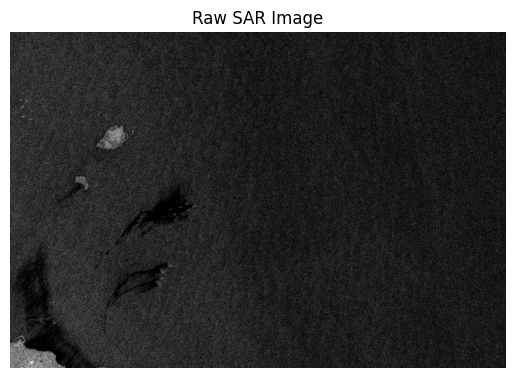

In [136]:
# Load SAR image
sar_image = cv2.imread(SAR_image_path, cv2.IMREAD_GRAYSCALE)

plt.imshow(sar_image.squeeze(), cmap="gray")
plt.title("Raw SAR Image")
plt.axis("off")
plt.show()

In [ ]:
# Pad the image to make dimensions divisible by the patch_size
pad_h = (patch_size - (sar_image.shape[0] % patch_size)) % patch_size
pad_w = (patch_size - (sar_image.shape[1] % patch_size)) % patch_size

padded_image = np.pad(sar_image, ((0, pad_h), (0, pad_w)), mode='constant', constant_values=0)

In [ ]:
# Split SAR image into patches
sar_patches = split_image_into_patches(padded_image, patch_size, step_size)
print(f"Number of SAR patches: {len(sar_patches)}")

Number of SAR patches: 70


In [ ]:
# Filter out land and edge patches from SAR patches
filtered_sar_patches, valid_indices = filter_water_patches(sar_patches, threshold=40)
print(f"Number of valid patches: {len(valid_indices)}")

Number of valid patches: 69


In [ ]:
plot_images(filtered_sar_patches)

In [147]:
# predict GTM for valid patches

predictions = []
for input_image in filtered_sar_patches:
    # Ensure correct shape for the generator
    input_image = tf.expand_dims(tf.expand_dims(input_image, axis=0), axis=-1)
    prediction = generator(tf.cast(input_image, tf.float32), training=False)
    predictions.append(prediction.numpy().squeeze())


In [ ]:
plot_images(predictions)

In [151]:
reconstructed_gtm = reconstruct_image_from_patches(predictions, valid_indices, sar_image.shape)

---


